# 002_SAM 실습



## 패키지 설치하기


In [2]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install pycocotools==2.0.6

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-uv61f9d0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-uv61f9d0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=a0e7cb00ce1792e299cc9c481ee8995b5b0da11198dcf7346480bb80efff5df6
  Stored in directory: /tmp/pip-ephem-wheel-cache-nfieenfy/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp311-cp311-linux_x86_64.whl size=400429 sha256=f000ca128b747ab0e1ab16d74b2ac

## 패키지 불러오기

In [3]:
import os
import urllib

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import SamPredictor, sam_model_registry

## *모델* 다운로드하기


In [4]:
CHECKPOINT_PATH = os.path.join("checkpoint")
CHECKPOINT_NAME = "sam_vit_h_4b8939.pth"
CHECKPOINT_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH, exist_ok=True)
checkpoint = os.path.join(CHECKPOINT_PATH, CHECKPOINT_NAME)
if not os.path.exists(checkpoint):
    urllib.request.urlretrieve(CHECKPOINT_URL, checkpoint)

## *모델* 불러오기

In [7]:
sam = sam_model_registry["vit_h"](checkpoint=checkpoint).to(DEVICE)
predictor = SamPredictor(sam)

## 예제 이미지 불러오기

In [8]:
IMAGE_PATH = "mannequin.jpg"
image = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

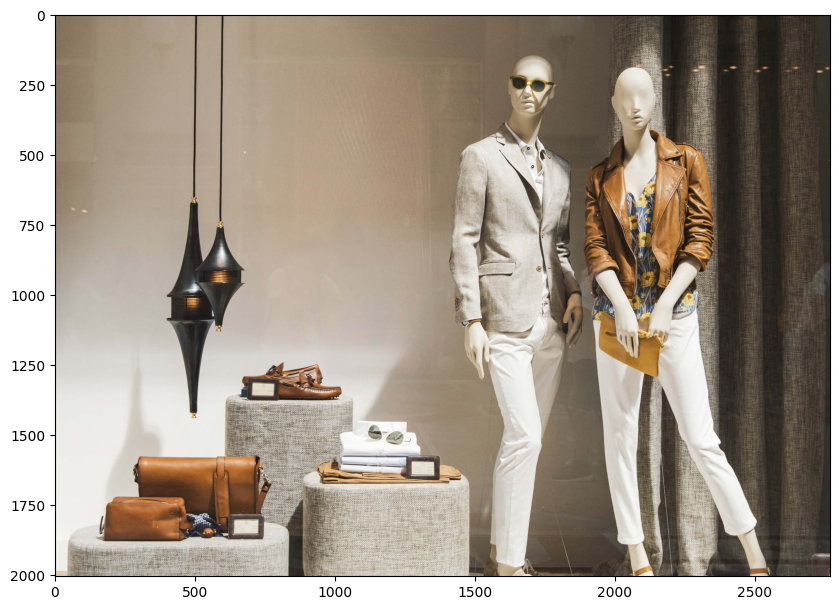

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("on")
plt.show()

## Prompt 포인트 좌표 입력 만들기

원하는 위치의 객체를 segmentation 하기 위해서는 원하는 위치를 Point로 입력해야합니다. SAM 모델에 Point를 입력하기 위해서는 두 가지 정보가 필요합니다.

- point_coords: Point 좌표 (x, y)
- points_labels: Point의 타입. Point 위치의 객체를 선택하려면 Positive Click(1)로 설정.

In [10]:
point_coords = np.array([[1720, 230]])
points_labels = np.array([1])

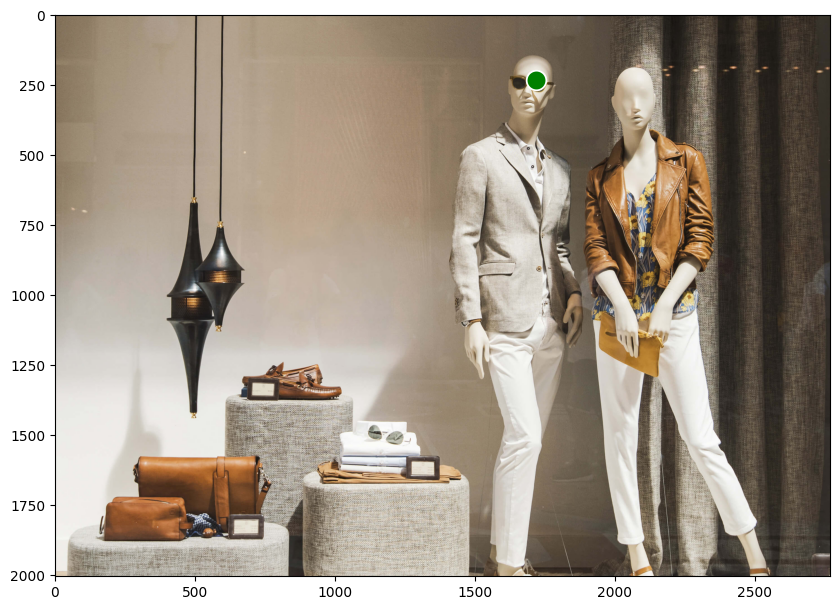

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.gca().scatter(
    point_coords[0, 0],
    point_coords[0, 1],
    color="green",
    marker="o",
    s=200,
    edgecolor="white",
    linewidth=1.25,
)
plt.axis("on")
plt.show()

## SAM 모델 추론하기

- masks: 입력한 정보에 대해 3개의 mask가 출력.
- scores: 3개의 mask의 퀄리티에 대한 모델의 평가 점수. 점수가 가장 높을수록 퀄리티가 높은 mask입니다.
- low_res_logits: 저해상도 mask 출력. 이 예제에서는 사용하지 않습니다.

In [12]:
predictor.set_image(image)
masks, scores, _ = predictor.predict(point_coords, points_labels)

Mask 0


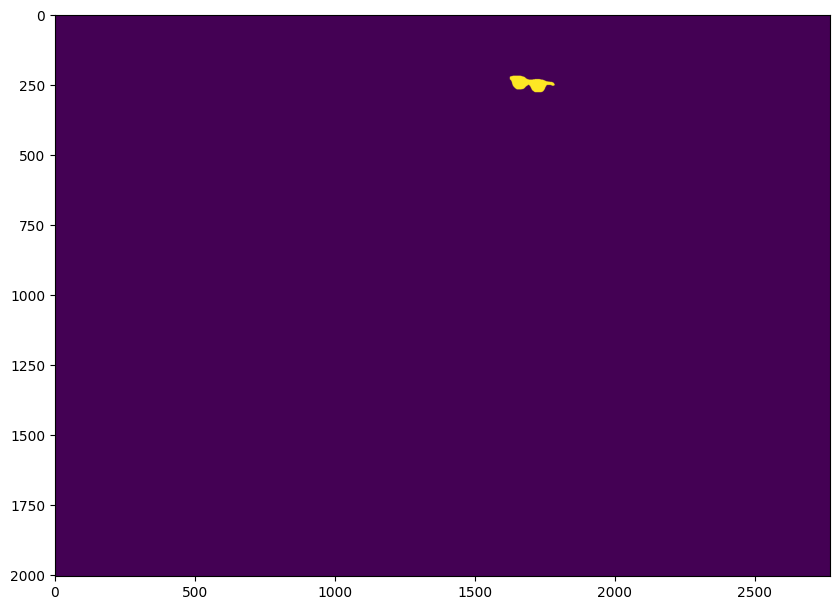

Mask 1


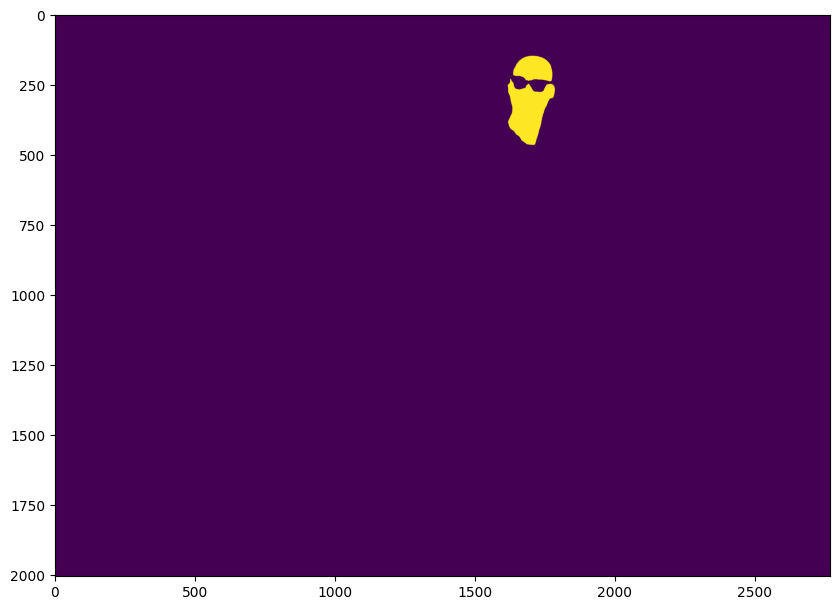

Mask 2


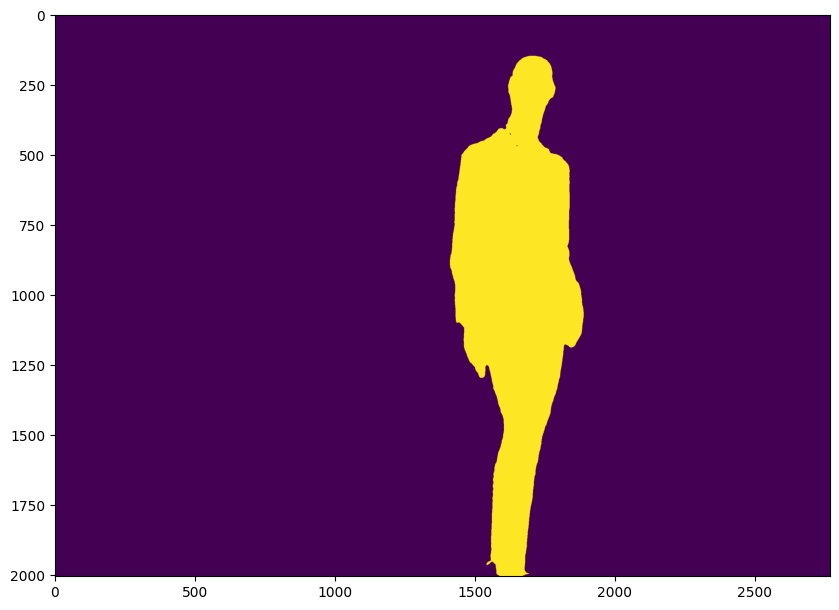

In [13]:
for i, mask in enumerate(masks):
    print(f"Mask {i}")
    plt.figure(figsize=(10, 10))
    plt.imshow(mask)
    plt.axis("on")
    plt.show()

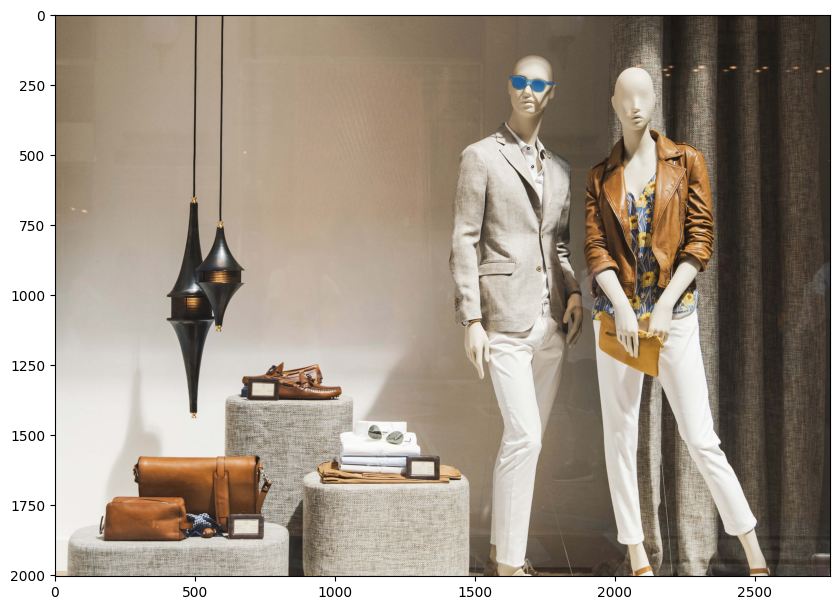

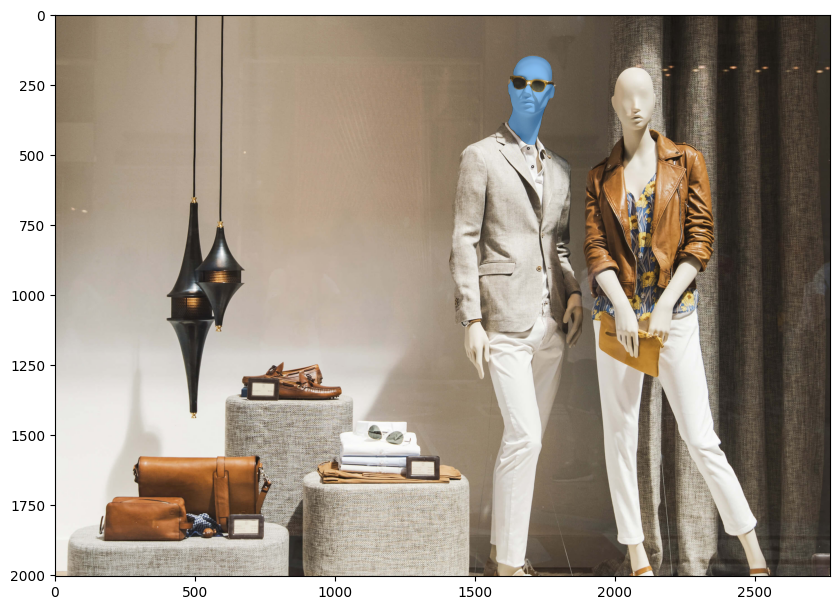

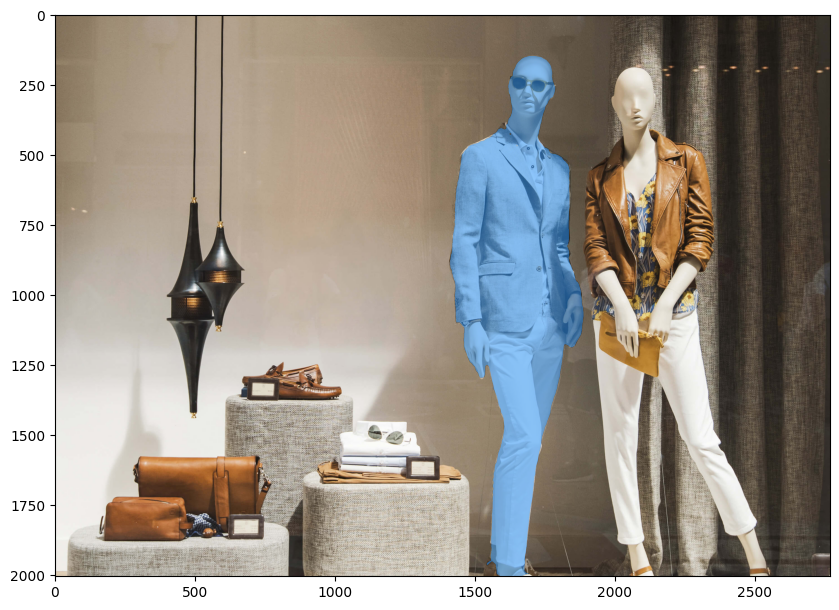

In [14]:
color = np.array([30/255, 144/255, 255/255, 0.5])

for mask in masks:
    mask_image = np.expand_dims(mask, axis=-1) * color.reshape(1, 1, -1)
    mask_image = (mask_image * 255).astype(np.uint8)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.imshow(mask_image)
    plt.axis("on")
    plt.show()

## 평가 점수를 이용해 세그멘테이션 마스크 선택하기

In [15]:
scores

array([0.92273325, 0.8487083 , 0.9595021 ], dtype=float32)

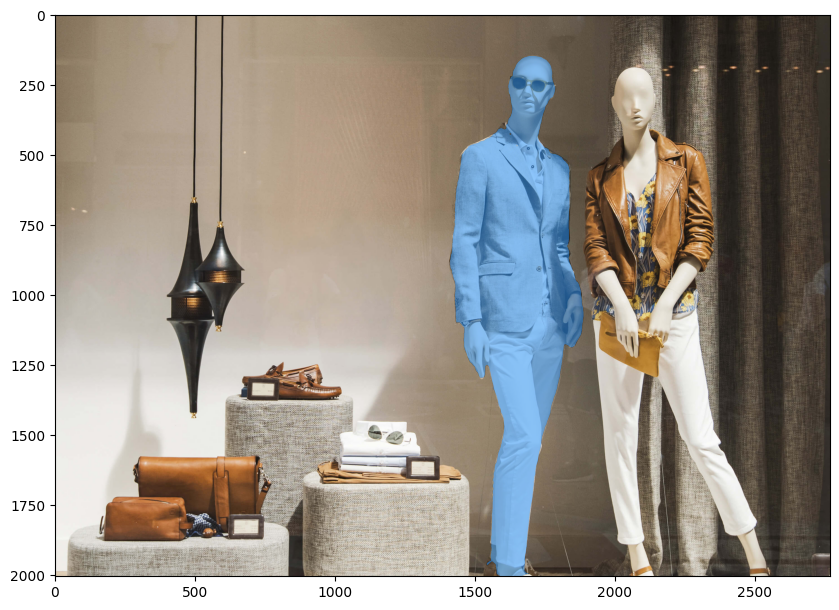

In [16]:
mask = masks[np.argmax(scores)]

color = np.array([30/255, 144/255, 255/255, 0.5])
mask_image = np.expand_dims(mask, axis=-1) * color.reshape(1, 1, -1)
mask_image = (mask_image * 255).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask_image)
plt.axis("on")
plt.show()